# Notebook Take 3

## Imports

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, cross_validate
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer
import numpy as np
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading in data
years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
dfs = []
for year in years:
    df = pd.read_csv(f'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_{year}.csv')
    df['year'] = year
    dfs.append(df)
match_df = pd.concat(dfs)

## Data Exploration

In [3]:
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17675 entries, 0 to 1925
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          17675 non-null  object 
 1   tourney_name        17675 non-null  object 
 2   surface             17675 non-null  object 
 3   draw_size           17675 non-null  int64  
 4   tourney_level       17675 non-null  object 
 5   tourney_date        17675 non-null  int64  
 6   match_num           17675 non-null  int64  
 7   winner_id           17675 non-null  int64  
 8   winner_seed         7464 non-null   object 
 9   winner_entry        2549 non-null   object 
 10  winner_name         17675 non-null  object 
 11  winner_hand         17670 non-null  object 
 12  winner_ht           17527 non-null  float64
 13  winner_ioc          17675 non-null  object 
 14  winner_age          17674 non-null  float64
 15  loser_id            17675 non-null  int64  
 16  loser

## Data Cleaning

### Dropping initial unecessary columns

In [4]:
# Tournament id is not going to be helpful with overall predictions but could be for individual tournaments
# Country of origin not needed
# winner_entry and seed are basically same thing so only need one
# score not needed if we know who already won
# hand not really necessary?
match_df = match_df.drop(columns = ['tourney_id', 'tourney_name', 'tourney_level', 'winner_ioc', 'loser_ioc',
                                   'match_num', 'winner_entry', 'loser_entry', 'score', 'winner_hand', 'loser_hand'])

### Dealing with Nan's

In [6]:
# Going to start with winner and loser seed
# nan values are probably players that are not seeded at tournaments
match_df['winner_seed'].unique()

array([nan, 7.0, 6.0, 8.0, 2.0, 4.0, 3.0, 1.0, 5.0, 28.0, 14.0, 9.0, 26.0,
       27.0, 19.0, 15.0, 12.0, 24.0, 29.0, 30.0, 23.0, 13.0, 21.0, 25.0,
       31.0, 18.0, 10.0, 16.0, 32.0, 17.0, 11.0, 22.0, 20.0, 33.0, '1',
       '2', '3', '6', '7', '8', '4', '5', '25', '17', '16', '19', '31',
       'WC', 'Q', '23', '14', '10', '18', '28', '32', '11', '15', '20',
       '26', '27', '24', '9', '13', '12', '33', '29', '30', '21', '22',
       'LL'], dtype=object)

In [7]:
# nr stands for not ranked
match_df['winner_seed'] = match_df['winner_seed'].replace(np.nan, '0').replace('WC', '0').replace(
'LL', '0').replace('Q', '0')

In [8]:
# Replacing loser nulls
match_df['loser_seed'] = match_df['loser_seed'].replace(np.nan, '0').replace('WC', '0').replace(
'LL', '0').replace('Q', '0')

In [9]:
# winner_ht, going to replace with mode
# most atp players are about 6' 1"
match_df['winner_ht'].unique()

array([183., 185., 193., 180., 188., 178., 196., 198., 181., 173., 190.,
       175., 172., 191., 206., 203., 170.,  nan, 189., 174., 208., 186.,
       201., 211., 194., 163.])

In [10]:
replace = match_df['winner_ht'].fillna(match_df['winner_ht'].mode()[0], inplace = True)

In [11]:
replace0 = match_df['loser_ht'].fillna(match_df['winner_ht'].mode()[0], inplace = True)

In [12]:
# Winner and loser age
# one null in each so just fill with mode 
replace2 = match_df['winner_age'].fillna(match_df['winner_age'].mode()[0], inplace = True)

In [13]:
replace3 = match_df['loser_age'].fillna(match_df['loser_age'].mode()[0], inplace = True)

We are going to drop null values for game data. We fill it would be inaccurate to try and fill matches with game data based on measures of central tendency.

In [14]:
match_df = match_df.dropna()

### Converting Datatypes to Numeric
We do not have any nulls now. To compare our columns and make models in the future, we need to get our categorical columns to become numeric

In [15]:
# Surface has 3 values so we are going to encode it
match_df["surface"] = match_df["surface"].astype('category')
match_df.dtypes
match_df["surface_cat"] = match_df["surface"].cat.codes

Now, since we have surface_cats as an int, we no longer need 'surface'

In [16]:
match_df = match_df.drop(columns = 'surface')

Next, we are going to change winner and loser seeds to integers

In [17]:
match_df['winner_seed'] = match_df['winner_seed'].astype(int)
match_df['loser_seed'] = match_df['loser_seed'].astype(int)

For our round column, we are going to remove 'R' from values such as 'R32'. We are also going to drop 'B' and 'BR' which stand for bye and bye round. We are also going to get rid of matches with 'RR'. This stands for round robin and these matches typically do not affect rankings and are uneeded.

In [18]:
match_df = match_df.loc[match_df['round'] != 'RR']
match_df = match_df.loc[match_df['round'] != 'B']
match_df = match_df.loc[match_df['round'] != 'BR']

In [19]:
match_df['round'] = match_df['round'].str.replace('R', '')

In [20]:
match_df['round'].unique()

array(['32', '16', 'QF', 'SF', 'F', '128', '64'], dtype=object)

The last thing we are doing for round is replacing QF, F, and SF with the number of players in those rounds.

In [21]:
match_df['round'] = match_df['round'].str.replace('QF', '8').replace('SF', '4').replace('F', '2')

In [22]:
match_df['round'] = match_df['round'].astype(int)

In [23]:
match_df = match_df.reset_index(drop=True)

### Aggregate player stats
In order for our model to not have target/data leakage, we are changing the columns to describe their career averages (career stats limited to results within this data's timeframe). Each row will still represent a match with two competitors, but the other columns describing matchplay will not be specific to that individual match, therefore the model should not be using future data to predict future results.

In [33]:
X_train['tourney_date'] = pd.to_datetime(X_train['tourney_date'], format='%Y%m%d')

In [34]:
X_train['prev_year'] = X_train['tourney_date'].dt.year - 1

In [35]:
X_trainW = X_train.groupby(['winner_id', 'year', 'surface_cat']).mean()[['w_df',             
'w_svpt',             
   'w_1stIn',            
   'w_1stWon',           
   'w_2ndWon',           
'w_SvGms',            
  'w_bpSaved',          
  'w_bpFaced',
                                                'w_ace'
    ]]

In [36]:
X_trainL = X_train.groupby(['loser_id', 'year', 'surface_cat']).mean()[['l_ace',              
  'l_df',               
  'l_svpt',             
  'l_1stIn',            
 'l_1stWon',           
  'l_2ndWon',           
  'l_SvGms',            
 'l_bpSaved',          
  'l_bpFaced',
    ]]

In [37]:
match_df = X_train.merge(X_trainW, 
              left_on = ['winner_id', 'prev_year', 'surface_cat'], 
              right_on = ['winner_id', 'year', 'surface_cat'],
              suffixes = ('_match', '_winner'),
              how = 'left')

In [38]:
match_df = match_df.merge(X_trainL, 
              left_on = ['loser_id', 'prev_year', 'surface_cat'], 
              right_on = ['loser_id', 'year', 'surface_cat'],
              suffixes = ('_match', '_loser'),
              how = 'left')

In [39]:
match_df = match_df.drop(columns = ['w_ace_match',
       'w_df_match', 'w_svpt_match', 'w_1stIn_match', 'w_1stWon_match',
       'w_2ndWon_match', 'w_SvGms_match', 'w_bpSaved_match', 'w_bpFaced_match',
       'l_ace_match', 'l_df_match', 'l_svpt_match', 'l_1stIn_match',
       'l_1stWon_match', 'l_2ndWon_match', 'l_SvGms_match', 'l_bpSaved_match',
       'l_bpFaced_match', ])

In [40]:
winners_r = match_df['winner_rank']

In [41]:
losers_r = match_df['loser_rank']

## Initial fav_win column
In order for us to engineer the data in terms of favorite, which will allow our model to have an easily identifiable target, we have to include a column that outputs boolean True or False to whether or not the favorite won. This is calculated by looking at player rankings going into any individual match, which was provided in the original dataset.

In [43]:
favorites = []
for i in list(range(0, 11636)):
    if winners_r[i] > losers_r[i]:             
        favorites.append(False)
    elif winners_r[i] < losers_r[i]:
        favorites.append(True)
favorites

[True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,

In [44]:
match_df['fav_win'] = favorites

In [45]:
match_df = match_df.drop(columns = ['winner_seed', 'loser_seed', 'winner_rank_points', 'loser_rank_points', 'minutes'])

In [46]:
fav_win_T = match_df.loc[match_df['fav_win'] == True]

In [47]:
fav_win_T['fav_rank_diff'] = fav_win_T['winner_rank'] - fav_win_T['loser_rank']
fav_win_T['fav_bpFaced_diff'] = fav_win_T['w_bpFaced_winner'] - fav_win_T['l_bpFaced_loser']
fav_win_T['fav_bpSaved_diff'] = fav_win_T['w_bpSaved_winner'] - fav_win_T['l_bpSaved_loser']
fav_win_T['fav_SvGms_diff'] = fav_win_T['w_SvGms_winner'] - fav_win_T['l_SvGms_loser']
fav_win_T['fav_2ndWon_diff'] = fav_win_T['w_2ndWon_winner'] - fav_win_T['l_2ndWon_loser']
fav_win_T['fav_1stWon_diff'] = fav_win_T['w_1stWon_winner'] - fav_win_T['l_1stWon_loser']
fav_win_T['fav_1stIn_diff'] = fav_win_T['w_1stIn_winner'] - fav_win_T['l_1stIn_loser']
fav_win_T['fav_svpt_diff'] = fav_win_T['w_svpt_winner'] - fav_win_T['l_svpt_loser']
fav_win_T['fav_df_diff'] = fav_win_T['w_df_winner'] - fav_win_T['l_df_loser']
fav_win_T['fav_ace_diff'] = fav_win_T['w_ace_winner'] - fav_win_T['l_ace_loser']
fav_win_T['fav_age_diff'] = fav_win_T['winner_age'] - fav_win_T['loser_age']
fav_win_T['fav_ht_diff'] = fav_win_T['winner_ht'] - fav_win_T['loser_ht']

In [48]:
# dropping not diff columns
fav_win_T = fav_win_T.drop(columns = ['w_df_winner',
       'w_svpt_winner', 'w_1stIn_winner', 'w_1stWon_winner', 'w_2ndWon_winner',
       'w_SvGms_winner', 'w_bpSaved_winner', 'w_bpFaced_winner',
       'w_ace_winner', 'l_ace_loser', 'l_df_loser', 'l_svpt_loser',
       'l_1stIn_loser', 'l_1stWon_loser', 'l_2ndWon_loser', 'l_SvGms_loser',
       'l_bpSaved_loser', 'l_bpFaced_loser', 'winner_ht', 'loser_ht', 'winner_age', 'loser_age'])

In [52]:
fav_win_F = match_df.loc[match_df['fav_win'] == False]

In [53]:
fav_win_F['fav_rank_diff'] =fav_win_F['loser_rank'] - fav_win_F['winner_rank'] 
fav_win_F['fav_bpFaced_diff'] =fav_win_F['l_bpFaced_loser'] - fav_win_F['w_bpFaced_winner']  
fav_win_F['fav_bpSaved_diff'] =fav_win_F['l_bpSaved_loser'] - fav_win_F['w_bpSaved_winner']  
fav_win_F['fav_SvGms_diff'] =fav_win_F['l_SvGms_loser'] - fav_win_F['w_SvGms_winner'] 
fav_win_F['fav_2ndWon_diff'] =fav_win_F['l_2ndWon_loser'] - fav_win_F['w_2ndWon_winner']  
fav_win_F['fav_1stWon_diff'] =fav_win_F['l_1stWon_loser'] - fav_win_F['w_1stWon_winner']  
fav_win_F['fav_1stIn_diff'] =fav_win_F['l_1stIn_loser'] - fav_win_F['w_1stIn_winner'] 
fav_win_F['fav_svpt_diff'] =fav_win_F['l_svpt_loser'] - fav_win_F['w_svpt_winner'] 
fav_win_F['fav_df_diff'] =fav_win_F['l_df_loser'] - fav_win_F['w_df_winner']  
fav_win_F['fav_ace_diff'] =fav_win_F['l_ace_loser'] - fav_win_F['w_ace_winner']  
fav_win_F['fav_age_diff'] =fav_win_F['loser_age'] - fav_win_F['winner_age'] 
fav_win_F['fav_ht_diff'] =fav_win_F['loser_ht'] - fav_win_F['winner_ht'] 

In [54]:
fav_win_F = fav_win_F.drop(columns = ['w_df_winner',
       'w_svpt_winner', 'w_1stIn_winner', 'w_1stWon_winner', 'w_2ndWon_winner',
       'w_SvGms_winner', 'w_bpSaved_winner', 'w_bpFaced_winner',
       'w_ace_winner', 'l_ace_loser', 'l_df_loser', 'l_svpt_loser',
       'l_1stIn_loser', 'l_1stWon_loser', 'l_2ndWon_loser', 'l_SvGms_loser',
       'l_bpSaved_loser', 'l_bpFaced_loser', 'winner_ht', 'loser_ht', 'winner_age', 'loser_age'])

In [55]:
agg_df = pd.concat([fav_win_T, fav_win_F])

In [56]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11636 entries, 0 to 11629
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   draw_size         11636 non-null  int64         
 1   tourney_date      11636 non-null  datetime64[ns]
 2   winner_id         11636 non-null  int64         
 3   winner_name       11636 non-null  object        
 4   loser_id          11636 non-null  int64         
 5   loser_name        11636 non-null  object        
 6   best_of           11636 non-null  int64         
 7   round             11636 non-null  int32         
 8   winner_rank       11636 non-null  float64       
 9   loser_rank        11636 non-null  float64       
 10  year              11636 non-null  int64         
 11  surface_cat       11636 non-null  int8          
 12  prev_year         11636 non-null  int64         
 13  fav_win           11636 non-null  bool          
 14  fav_rank_diff     1163

## Model-less Baseline

In [57]:
agg_df['fav_win'].value_counts()

True     7455
False    4181
Name: fav_win, dtype: int64

In [58]:
7455 / len(agg_df['fav_win'])

0.6406840838776212

Our model-less baseline is 64% accurate if you were to predict that the favorite won every time.

## Creating fav_win column, our target

This column will allow us to see if the favorite won the match or not.

In [69]:
winners_r = agg_df['winner_rank']
losers_r = agg_df['loser_rank']
winners_r

0         82.0
2         86.0
4         13.0
5         12.0
6         21.0
         ...  
11616    274.0
11621     85.0
11625     82.0
11627    119.0
11629     75.0
Name: winner_rank, Length: 11636, dtype: float64

In [70]:
favorites = []
for i in list(range(0, 11636)):
    if winners_r[i] > losers_r[i]:             
        favorites.append(False)
    elif winners_r[i] < losers_r[i]:
        favorites.append(True)
favorites

[True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,

In [71]:
agg_df['fav_win'] = favorites

In [72]:
agg_df['fav_win'].value_counts()

True     7455
False    4181
Name: fav_win, dtype: int64

## Splitting Data
Seperating our data into a train-test split including a hold out set of the past two years for our final model to test and be evaluated on.

In [73]:
test_df = agg_df.loc[match_df['year'] >= 2021]

In [74]:
X = agg_df.drop(columns='fav_win')
y = agg_df['fav_win']
# Preparing our hold out data for train test split
X_cols = X.columns
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=42, test_size=len(test_df))
X_test, X_hold, y_test, y_hold = train_test_split(X_test, y_test, test_size=500, shuffle=False)

In [75]:
X_train.columns

Index(['draw_size', 'tourney_date', 'winner_id', 'winner_name', 'loser_id',
       'loser_name', 'best_of', 'round', 'winner_rank', 'loser_rank', 'year',
       'surface_cat', 'prev_year', 'fav_rank_diff', 'fav_bpFaced_diff',
       'fav_bpSaved_diff', 'fav_SvGms_diff', 'fav_2ndWon_diff',
       'fav_1stWon_diff', 'fav_1stIn_diff', 'fav_svpt_diff', 'fav_df_diff',
       'fav_ace_diff', 'fav_age_diff', 'fav_ht_diff'],
      dtype='object')

In [76]:
X_train = X_train.drop(columns = ['tourney_date', 'winner_name', 'loser_name', 'winner_id', 'loser_id', 'prev_year'])
X_test = X_test.drop(columns = ['tourney_date', 'winner_name', 'loser_name', 'winner_id', 'loser_id', 'prev_year'])

## Function

In [77]:
def evaluate(model,Xtr,Xte,ytr,yte):
    train_preds = model.predict(Xtr)
    test_preds = model.predict(Xte)

    train_probas = model.predict_proba(Xtr)[:,1]
    test_probas = model.predict_proba(Xte)[:,1]
    
    plot_confusion_matrix(model,Xte,yte)
    
    plot_roc_curve(model,Xte,yte)
    
    print(f"Train Accuracy: {accuracy_score(ytr,train_preds):.4f}")
    print(f"Train F1: {f1_score(ytr,train_preds):.4f}")
    print(f"Train Precision: {precision_score(ytr,train_preds):.4f}")
    print(f"Train Recall: {recall_score(ytr,train_preds):.4f}")
    print(f"Train ROC-AUC: {roc_auc_score(ytr,train_probas):.4f}")
    print('*'*20)
    print(f"Test Accuracy: {accuracy_score(yte,test_preds):.4f}")
    print(f"Test F1: {f1_score(yte,test_preds):.4f}")
    print(f"Test Precision: {precision_score(yte,test_preds):.4f}")
    print(f"Test Recall: {recall_score(yte,test_preds):.4f}")
    print(f"Test ROC-AUC: {roc_auc_score(yte,test_probas):.4f}")

## LOGREG MODEL 1

In [78]:
si = SimpleImputer()

si.fit(X_train)

X_train_im = si.transform(X_train)
X_test_im = si.transform(X_test)

In [79]:
scaler = StandardScaler()

scaler.fit(X_train_im)

X_train_sc = scaler.transform(X_train_im)
X_test_sc = scaler.transform(X_test_im)

In [80]:
logreg = LogisticRegression(random_state = 42)

logreg.fit(X_train_sc,y_train)

LogisticRegression(random_state=42)

Train Accuracy: 0.6458
Train F1: 0.7848
Train Precision: 0.6458
Train Recall: 1.0000
Train ROC-AUC: 0.5267
********************
Test Accuracy: 0.6343
Test F1: 0.7763
Test Precision: 0.6343
Test Recall: 1.0000
Test ROC-AUC: 0.5072


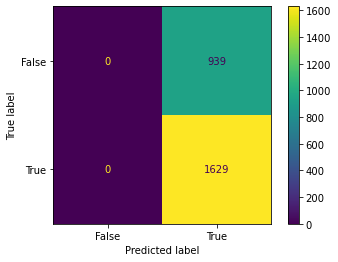

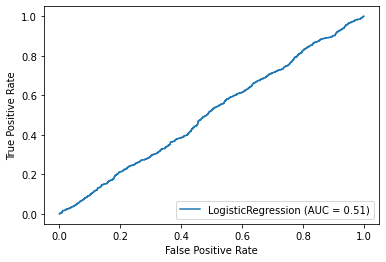

In [81]:
evaluate(logreg,X_train_sc,X_test_sc,y_train,y_test)

## Model 2: Decision Tree

In [83]:
tree = DecisionTreeClassifier(random_state = 42,max_depth = 5)

tree.fit(X_train_im, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

Train Accuracy: 0.6496
Train F1: 0.7861
Train Precision: 0.6489
Train Recall: 0.9967
Train ROC-AUC: 0.5266
********************
Test Accuracy: 0.6355
Test F1: 0.7762
Test Precision: 0.6357
Test Recall: 0.9963
Test ROC-AUC: 0.5168


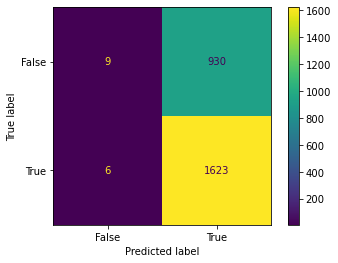

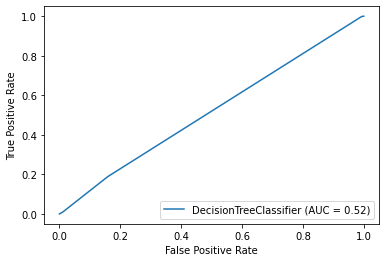

In [85]:
evaluate(tree,X_train_im,X_test_im,y_train,y_test)

## Model 3: Naive Bayes

In [87]:
clf_nb = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('naive_bayes', GaussianNB()),
])

clf_nb.fit(X_train_im,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('naive_bayes', GaussianNB())])

Train Accuracy: 0.6317
Train F1: 0.7692
Train Precision: 0.6460
Train Recall: 0.9503
Train ROC-AUC: 0.5117
********************
Test Accuracy: 0.6219
Test F1: 0.7622
Test Precision: 0.6341
Test Recall: 0.9552
Test ROC-AUC: 0.5087


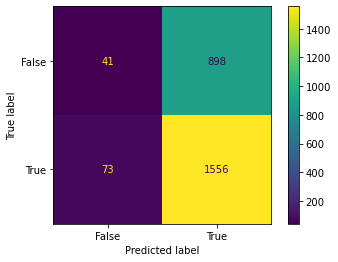

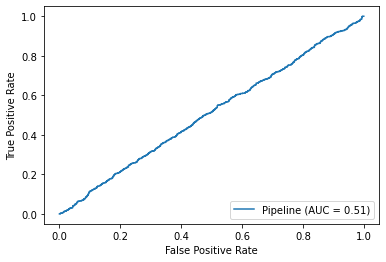

In [88]:
evaluate(clf_nb,X_train_im,X_test_im,y_train,y_test)

## Model 4: Random Forest

In [93]:
smote = SMOTE(random_state=42)
X_train_im, y_train = smote.fit_resample(X_train_im,y_train)

In [95]:
clf_rf = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('random forest', RandomForestClassifier(random_state=42,max_depth = 10)),
])

clf_rf.fit(X_train_im,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('random forest',
                 RandomForestClassifier(max_depth=10, random_state=42))])

In [96]:
cross_val_score(clf_rf,X_train_im,y_train, scoring='accuracy')

array([0.53206865, 0.52417533, 0.60912788, 0.84952553, 0.83687302])

In [100]:
cross_validate(clf_rf,X_train_im,y_train,scoring='accuracy',return_train_score = True)

{'fit_time': array([2.25679111, 2.28086925, 2.19070125, 2.36222625, 2.28118181]),
 'score_time': array([0.04691482, 0.04688907, 0.0468955 , 0.05234861, 0.07173419]),
 'test_score': array([0.53206865, 0.52417533, 0.60912788, 0.84952553, 0.83687302]),
 'train_score': array([0.86850429, 0.8778945 , 0.86851915, 0.85044618, 0.85067209])}

Train Accuracy: 0.8401
Train F1: 0.8569
Train Precision: 0.7756
Train Recall: 0.9572
Train ROC-AUC: 0.9392
********************
Test Accuracy: 0.6048
Test F1: 0.7344
Test Precision: 0.6401
Test Recall: 0.8613
Test ROC-AUC: 0.5069


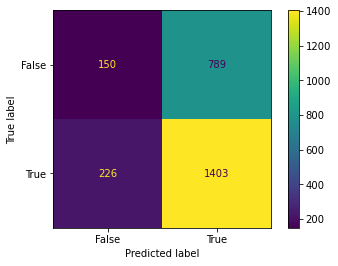

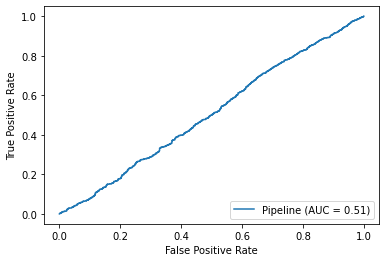

In [101]:
evaluate(clf_rf,X_train_im,X_test_im,y_train,y_test)

## Model 5: Random Forest with Grid Search

In [102]:
param_grid = {
    "random forest__criterion":['gini','entropy'],
    "random forest__max_depth": [1,2,3,4,5,10,15],
    "random forest__min_samples_leaf": [1,2,5,10,12,15],
    "random forest__min_samples_split": [2,4,6,8]
}

In [104]:
clf_rf = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('random forest', RandomForestClassifier(random_state=42)),
])

clf_rf.fit(X_train_im,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('random forest', RandomForestClassifier(random_state=42))])

In [105]:
gs = GridSearchCV(clf_rf,param_grid,cv = 5,scoring = 'accuracy')

gs.fit(X_train_im,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('random forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'random forest__criterion': ['gini', 'entropy'],
                         'random forest__max_depth': [1, 2, 3, 4, 5, 10, 15],
                         'random forest__min_samples_leaf': [1, 2, 5, 10, 12,
                                                             15],
                         'random forest__min_samples_split': [2, 4, 6, 8]},
             scoring='accuracy')

In [106]:
gs.best_params_

{'random forest__criterion': 'gini',
 'random forest__max_depth': 15,
 'random forest__min_samples_leaf': 1,
 'random forest__min_samples_split': 2}

In [108]:
gs.best_score_

0.6904153864554161

Train Accuracy: 0.9471
Train F1: 0.9496
Train Precision: 0.9080
Train Recall: 0.9951
Train ROC-AUC: 0.9962
********************
Test Accuracy: 0.6040
Test F1: 0.7313
Test Precision: 0.6419
Test Recall: 0.8496
Test ROC-AUC: 0.5171


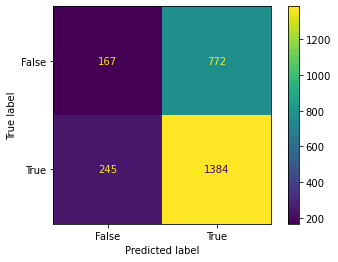

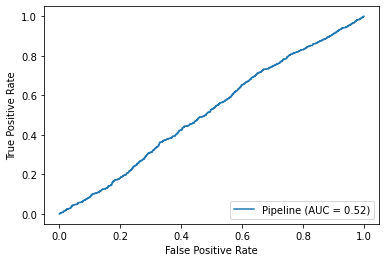

In [110]:
evaluate(gs.best_estimator_,X_train_im,X_test_im,y_train,y_test)